# Experiment 2: What persists, exists

> Conducting the second experiment that is training the cellular automaton to maintain its form after it has reached the desired shape.

In [1]:
#| default_exp what_persists_exists

In [2]:
#| hide
# from nbdev.showdoc import *

In [3]:
#| export
# import NeuralCellularAutomata_PyTorch.custom_attention
from NeuralCellularAutomata_PyTorch.core import *
from NeuralCellularAutomata_PyTorch.core import COLOR_N
from NeuralCellularAutomata_PyTorch.learning_to_grow import *

# from NeuralCellularAutomata_PyTorch.core import CHANNEL_N, load_image, TARGET_SIZE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [4]:
batch_size = 4
# n_epochs = 200
CHANNEL_N = 64


core_diameter = 4

In [5]:
# path = '../images/emoji_u1f98e.png'
path = '../images/bw.png'

In [6]:
# dna = torch.rand([CHANNEL_N, core_diameter, core_diameter])
# dna = F.normalize(torch.randn([CHANNEL_N, 2, 2]), dim=0).abs()

dna = (
    torch.eye(CHANNEL_N)[: core_diameter**2]
    .movedim(0, -1)
    .reshape([CHANNEL_N, core_diameter, core_diameter])
    .flip(0)
)

# dna = (
#     torch.eye(core_diameter**2)[: core_diameter**2]
#     .movedim(0, -1)
#     .reshape([core_diameter**2, core_diameter, core_diameter])
# )

# dna = F.interpolate(
#     torch.eye(core_diameter**2)[: core_diameter**2]
#     .movedim(0, -1)
#     .reshape([core_diameter**2, core_diameter, core_diameter]),
#     size=(CHANNEL_N,core_diameter,core_diameter)
# )

# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2), mode="circular").movedim(-1, 0)
# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2 * 2), mode="circular").movedim(-1, 0)
# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2 * 4), mode="circular").movedim(-1, 0)
# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2 * 8), mode="circular").movedim(-1, 0)

# foo = torch.ones_like(dna)
# foo[:core_diameter**2] = (foo - dna)[:core_diameter**2]
# dna = foo

# dna = torch.ones_like(dna) - dna
# dna[:COLOR_N] = 0


# for r, c in [
#     (0, 0),
#     (core_diameter - 1, 0),
#     (0, core_diameter - 1),
#     (core_diameter - 1, core_diameter - 1),
# ]:
#     dna[:, r, c] = 0.0
# dna[:, 1:, 1:] = 0.0

dna = dna[:CHANNEL_N]

dna = dna * CHANNEL_N

print(dna.shape)
print(dna)

torch.Size([64, 4, 4])
tensor([[[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0., 64.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[ 0., 64.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]],

        [[64.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.]]])


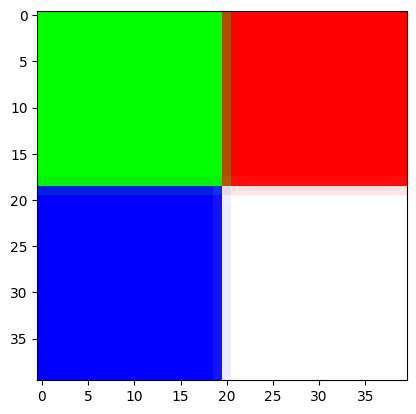

In [7]:
img_tensor = load_image(path)

# Pool Training

We want to create a pool of samples, that will contain different stages of the generation process as initial states.

In [8]:
# Samples
# | export
class SamplePool:
    def __init__(self, pool_size=1024, loss_fn=None, device=def_device):
        assert loss_fn is not None, "You need to provide a loss function"
        self.pool_size = pool_size
        self.loss_fn = loss_fn
        self.reset()

    def make_seed(self, sz=[1, CHANNEL_N, TARGET_SIZE, TARGET_SIZE]):
        seed = torch.zeros(sz).to(def_device)
        center_minus = (TARGET_SIZE - core_diameter) // 2
        center_plus = center_minus + core_diameter
        seed[:, :, center_minus:center_plus, center_minus:center_plus] = dna
        # seed[:, :, 5 : 5 + core_diameter, 5 : 5 + core_diameter] = dna
        return seed

    def reset(self):
        self.seed = self.make_seed()
        self.pool = self.seed.repeat(self.pool_size, 1, 1, 1)

    def sample(self, num_samples=8):
        # selecting a random sample from the pool
        self.idxs = torch.randperm(self.pool_size)[:num_samples]
        batch = self.pool[self.idxs, ...]

        # find the sample in the batch with the highest loss
        losses = self.loss_fn(batch[:, :COLOR_N, :, :])
        # and replace it with the seed
        # to avoid "catastrofic forgetting"
        # (i.e. forgetting how to generate the target from the seed)
        replace_idx = torch.argmax(losses).item()
        batch[replace_idx] = self.seed[0]

        return batch

    def update(self, new_samples):
        new_samples = new_samples.detach()
        # replace the old samples with the newly generated ones
        self.pool[self.idxs] = new_samples

In the SamplePool, we use a loss function to select the sample inside the batch with the highest loss and replace it with the original seed. To do so, we will use the MSE loss. 

In [9]:
# mse
#| export
def mse(pred, target, dim=1): 
    return ((pred - target) * (pred - target)).sum(dim).sum(dim=(1, 2))

In [10]:
loss_fn = partial(mse, target=img_tensor.repeat(batch_size, 1, 1, 1).to(def_device))

In [11]:
pool = SamplePool(1024, loss_fn=loss_fn)
batch = pool.sample(batch_size) #TODO: fix ugly here
batch.shape

torch.Size([4, 64, 40, 40])

We also need a function that will visualize a batch of inputs to validate that the sampling of the pool works as expected.

In [12]:
#| export 
def vis_batch(batch):
    B, C, H, W = batch.shape
    if C > COLOR_N:
        batch = batch[:, :COLOR_N, :, :]

    plt.figure(figsize=(16, 16))
    for i in range(B):
        plt.subplot(1, B, i + 1)
        assert type(batch) is torch.Tensor
        plt.imshow(batch[i].detach().cpu().permute(1, 2, 0).clamp(0,1))
        plt.axis('off')    

    plt.show()

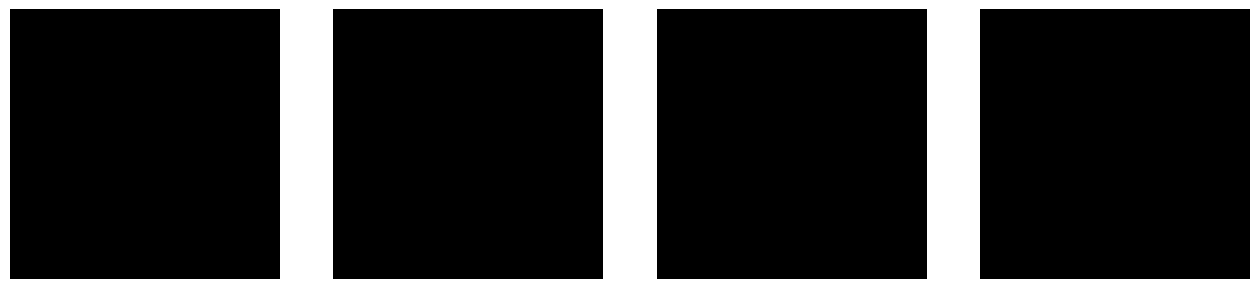

In [13]:
vis_batch(batch)

# Training Loop

In [14]:
# Instantiate the model
# |eval: false


ca = CAModel(CHANNEL_N, 1.0).to(def_device)


In [15]:
# Optimization

# ca.register_parameter("seed dna",dna)

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
# optimizer = torch.optim.Adam(ca.parameters(), lr=lr, betas=betas)
optimizer = torch.optim.Adam(ca.parameters())
# optimizer.add_param_group({"params": dna})
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

target = img_tensor.repeat(batch_size, 1, 1, 1)
# foo = list(batch.shape)
# foo[1] = COLOR_N
# target = img_tensor.broadcast_to(foo)
# target = img_tensor

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.5024890899658203 Steps: 17


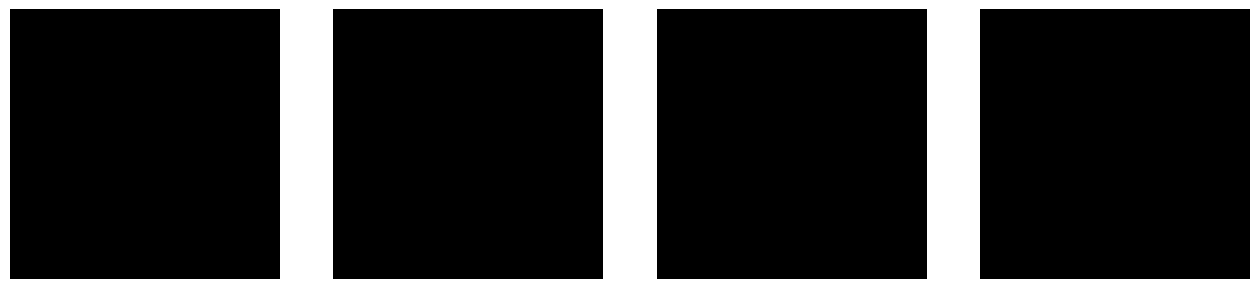

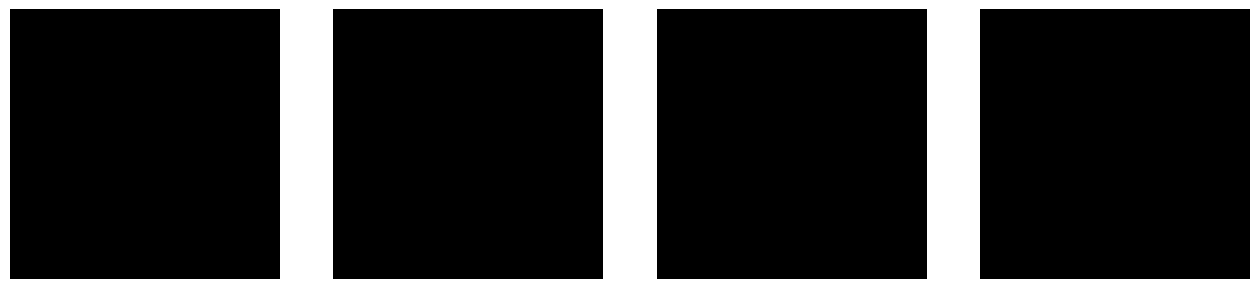

  5%|▌         | 5/100 [00:29<08:33,  5.41s/it]

Epoch: 5 Loss: 0.5024890899658203 Steps: 31


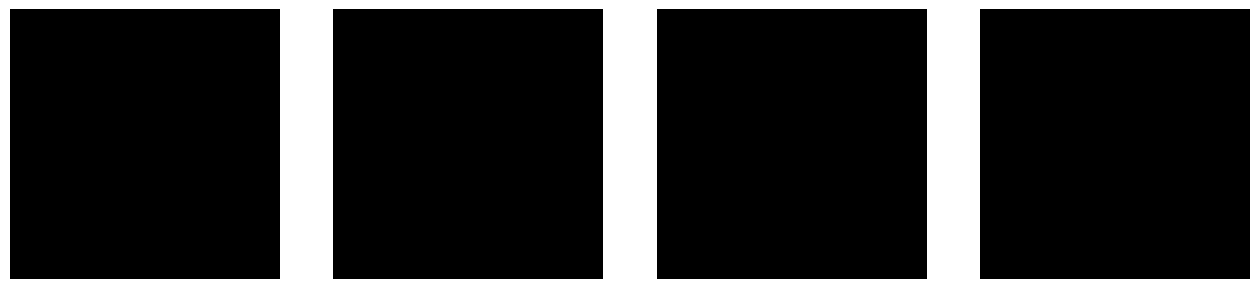

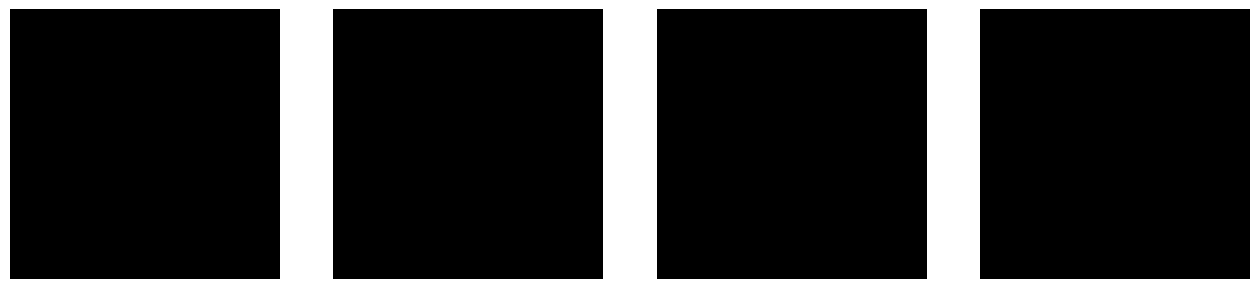

 10%|█         | 10/100 [01:16<11:02,  7.36s/it]

Epoch: 10 Loss: 0.5024890899658203 Steps: 18


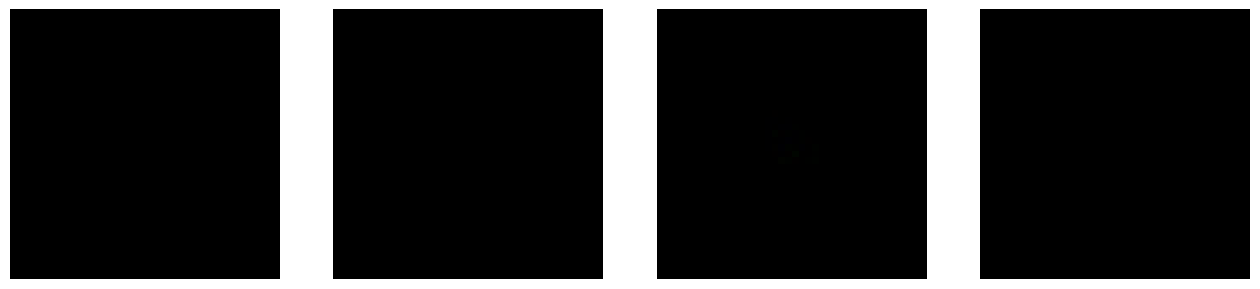

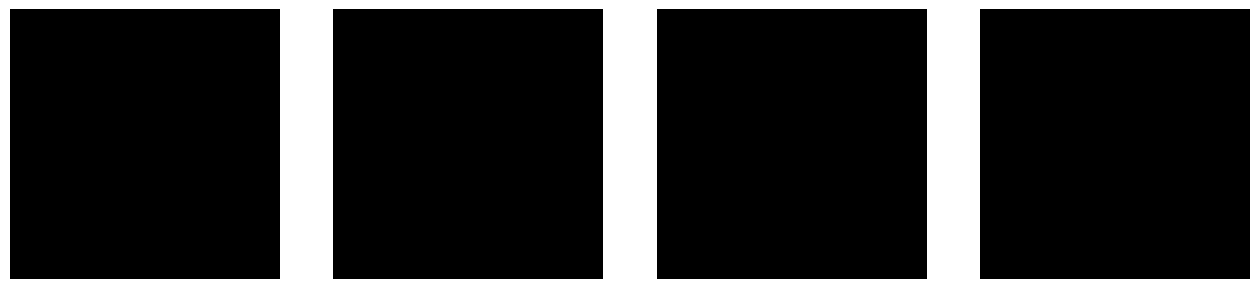

 15%|█▌        | 15/100 [01:36<07:13,  5.10s/it]

Epoch: 15 Loss: 0.5024890899658203 Steps: 25


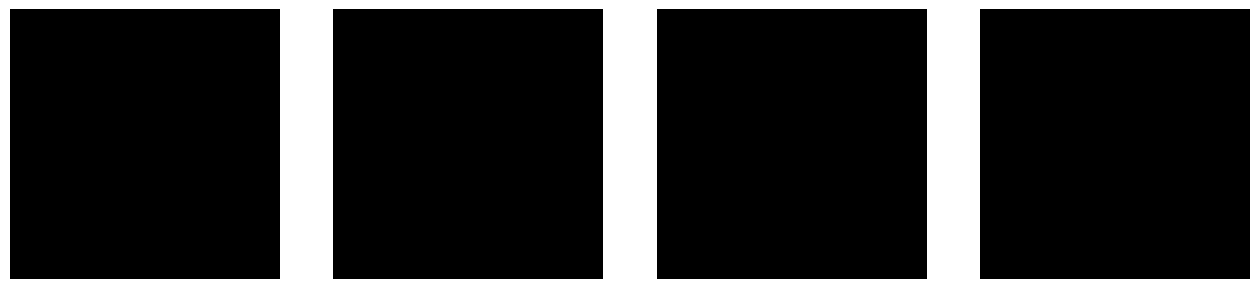

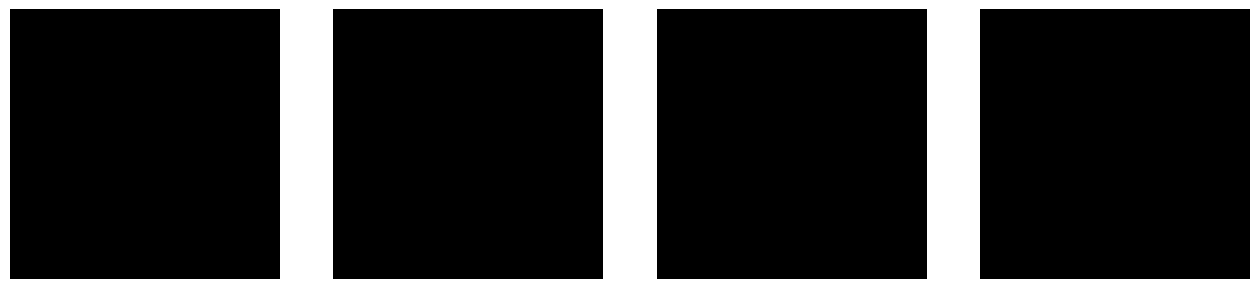

 20%|██        | 20/100 [01:54<04:16,  3.20s/it]

Epoch: 20 Loss: 0.5024890899658203 Steps: 26


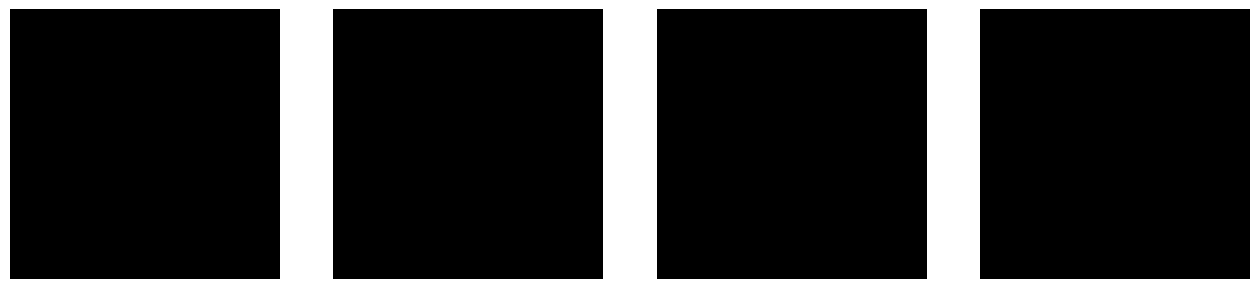

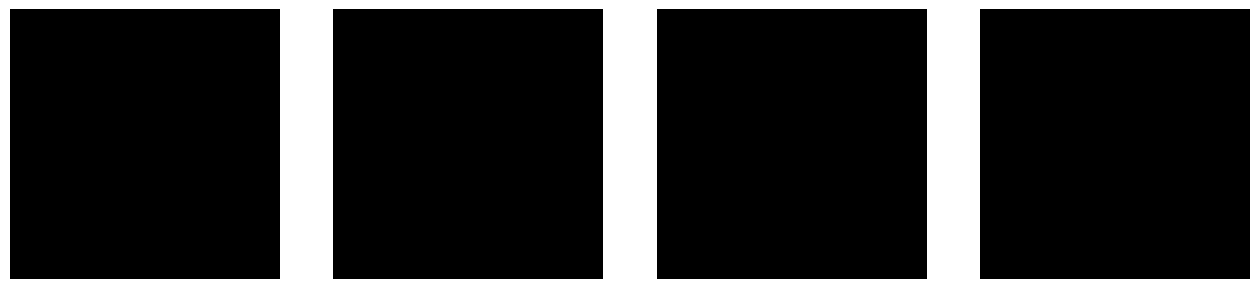

 25%|██▌       | 25/100 [02:22<06:04,  4.86s/it]

Epoch: 25 Loss: 0.5024890899658203 Steps: 25


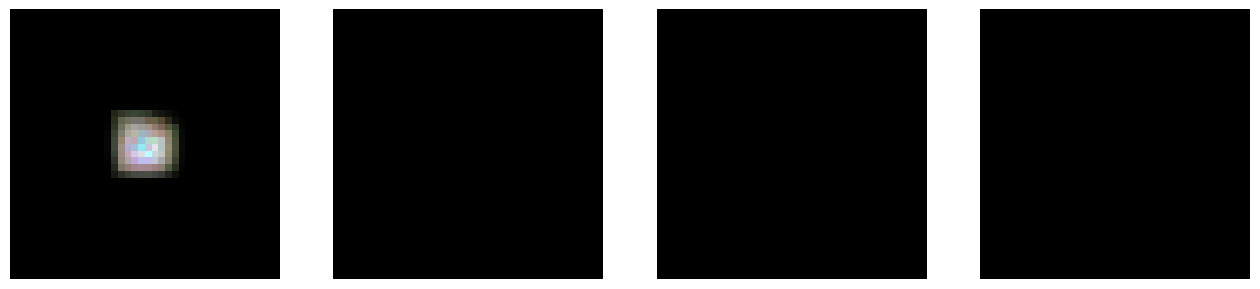

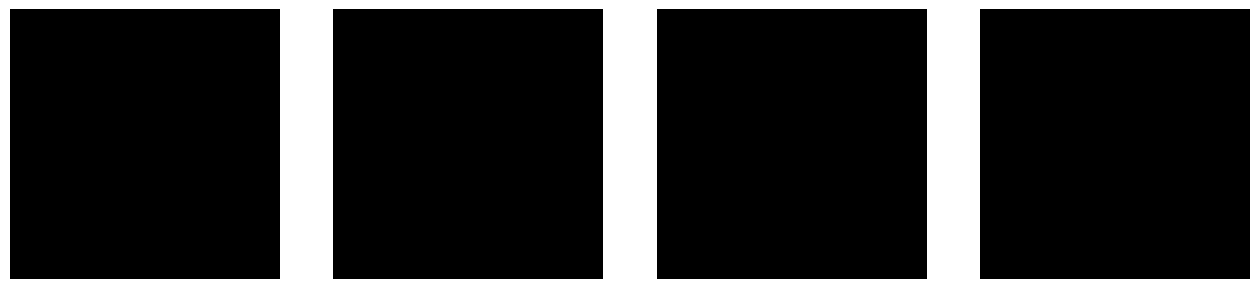

 30%|███       | 30/100 [02:59<07:36,  6.52s/it]

Epoch: 30 Loss: 0.5025005340576172 Steps: 8


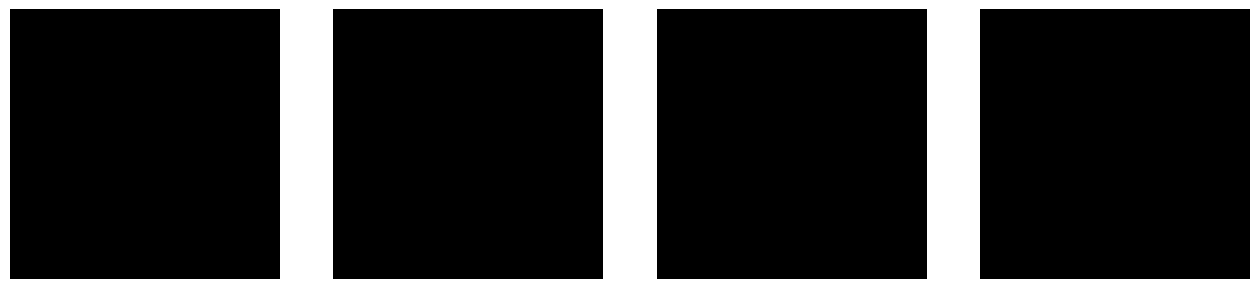

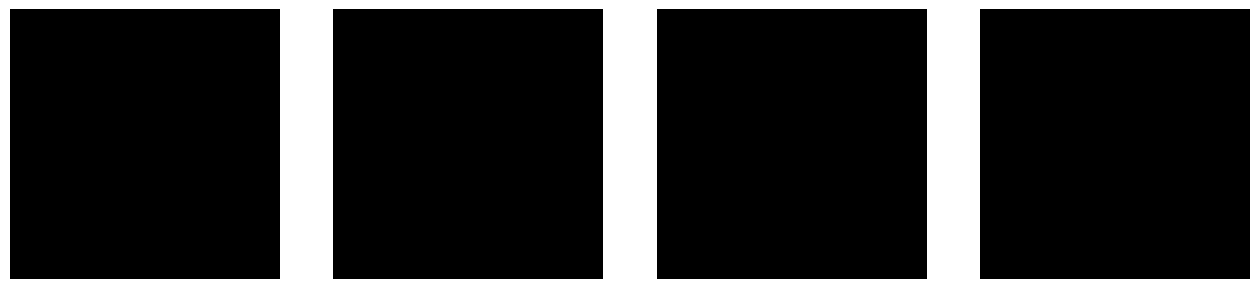

 35%|███▌      | 35/100 [03:36<08:27,  7.81s/it]

Epoch: 35 Loss: 0.5024890899658203 Steps: 14


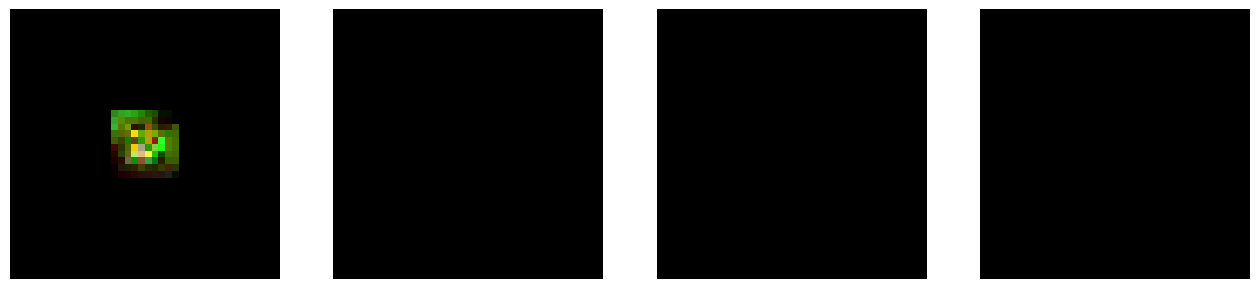

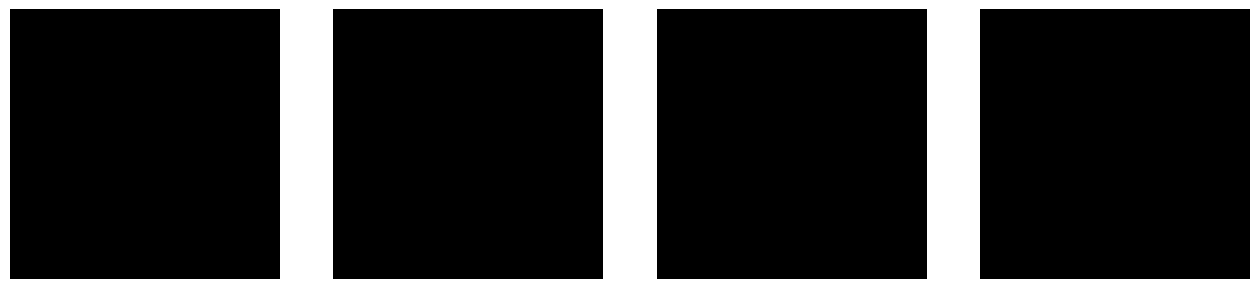

 40%|████      | 40/100 [04:03<05:48,  5.80s/it]

Epoch: 40 Loss: 0.5024890899658203 Steps: 26


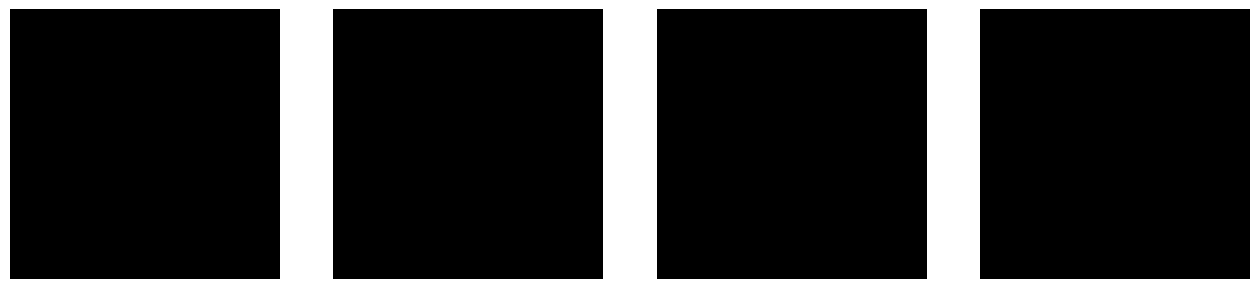

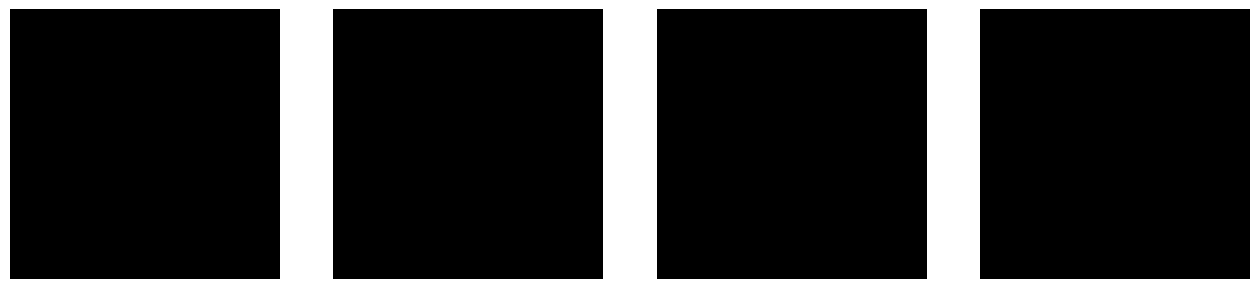

 41%|████      | 41/100 [04:18<06:12,  6.31s/it]


KeyboardInterrupt: 

In [22]:
# run the training
# |eval: false

n_epochs = 100

for i in tqdm(range(n_epochs)):
    # zero the optimizer
    optimizer.zero_grad()

    # set the number of steps to take
    steps = torch.randint(1, 32, (1,)).item()
    # steps = torch.randint(1, 8, (1,)).item()
    # steps = 4
    # steps = torch.randint(1, i // 4 + 2, (1,)).item()

    # sample the pool to get the input
    model_in = pool.sample(batch_size)

    # activate the model
    res = ca(model_in, steps=steps)

    # calculate the loss
    loss = F.mse_loss(
        res[:, :COLOR_N], target[:, :COLOR_N]
    )  # we only care about the RGBA channels

    # update the pool
    pool.update(res)

    # log the loss
    if i % (5) == 0:
        print(f"Epoch: {i} Loss: {loss.item()} Steps: {steps}")
        vis_batch(model_in)
        vis_batch(res)

    # backpropagate the loss and update the weights
    loss.backward()
    # print("stpeing")
    optimizer.step()
    # scheduler.step()

In [17]:
ca.state_dict()
# import save1
# ca.load_state_dict(save1.getSave())

OrderedDict([('brain.0.weight',
              tensor([[-0.0751,  0.1122, -0.1079,  ...,  0.0416,  0.0863, -0.0353],
                      [-0.1064, -0.0033, -0.0382,  ..., -0.0774, -0.0774,  0.0880],
                      [ 0.1041, -0.0068, -0.0249,  ...,  0.0805,  0.0745, -0.0166],
                      ...,
                      [-0.0388,  0.0508, -0.0738,  ...,  0.0828,  0.0537, -0.0669],
                      [ 0.0713, -0.1040, -0.0973,  ..., -0.0573, -0.0008, -0.0004],
                      [ 0.0905, -0.1157, -0.0270,  ...,  0.0979, -0.0195,  0.0892]])),
             ('brain.2.weight',
              tensor([[-0.0328, -0.0337,  0.0100,  ...,  0.0414,  0.0037,  0.0780],
                      [ 0.0574, -0.0396, -0.0637,  ...,  0.0370,  0.0875,  0.0445],
                      [-0.0372,  0.0109,  0.0590,  ...,  0.0134, -0.0864,  0.0419],
                      ...,
                      [ 0.0897, -0.0012, -0.0384,  ...,  0.0203,  0.0220,  0.0032],
                      [ 0.0196,  0.0554

In [18]:
#|eval: false

images = ca.grow_animation(pool.make_seed(), 32)
display_animation(images)

The automato manages to maintain it's shape as time passes. 

### Visualize a batch from the updated pool. 

During the training process we update the samples inside the pool. 
Let's visualize how a sample would look like after the training process is completed. 

In [19]:
#| eval: false
batch = pool.sample(batch_size)

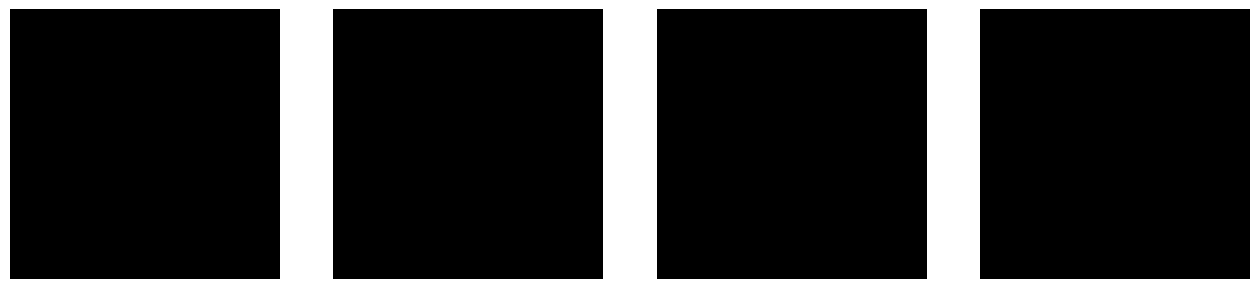

In [20]:
#| eval: false
vis_batch(batch)